#### I have use the combined data set from this competition and the orignal one . link to combined dataset [Combined](https://www.kaggle.com/datasets/devavratpatil/combined/data)

# Introduction

1. Importing libraries 

2. Loading and checking data

3. Data visualization

4. Data Pre_Processing & Feature engineering

    4.1 Outlier detection and removal
    
    4.2 Feature engineering 

    4.3 Normalization & Encoding categorical features

5. Spliting data

6. Model

    6.1  Model Architecture

    6.2  Hypertuning
    
    6.3  Learning and Validation curve

    6.4  Model training

7. Ensemble

8. Submission file

# Importing libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder , LabelEncoder , MinMaxScaler , StandardScaler
from sklearn.ensemble import VotingClassifier 
from sklearn.model_selection import train_test_split , cross_validate , learning_curve , validation_curve, cross_val_score , RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score , confusion_matrix ,log_loss, roc_auc_score,roc_curve

from scipy import stats

import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cat

import optuna 

## Loading Data

In [2]:
train_path = "/kaggle/input/combined/Combined.csv"
test_path = "/kaggle/input/playground-series-s4e1/test.csv"

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
print(train_df.shape)
print(test_df.shape)

(175032, 14)
(110023, 13)


In [5]:
train_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
train_df.duplicated().sum()

2

In [7]:
train_df = train_df.drop_duplicates()

In [8]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [9]:
train_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,175030.0,NaN,NaN,NaN,78089.659087,49639.679259,0.0,33761.25,77518.5,121275.75,165033.0
CustomerId,175030.0,NaN,NaN,NaN,15691944.50569,71428.441373,15565701.0,15632882.0,15690169.0,15756655.0,15815690.0
Surname,175030,2932,Hsia,2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,175030.0,NaN,NaN,NaN,656.114506,81.148932,350.0,597.0,659.0,710.0,850.0
Geography,175030,3,France,99226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,175030,2,Male,98604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,175030.0,NaN,NaN,NaN,38.171301,8.969551,18.0,32.0,37.0,42.0,92.0
Tenure,175030.0,NaN,NaN,NaN,5.019951,2.811144,0.0,3.0,5.0,7.0,10.0
Balance,175030.0,NaN,NaN,NaN,56677.296954,62982.318837,0.0,0.0,0.0,120727.97,250898.09
NumOfProducts,175030.0,NaN,NaN,NaN,1.553071,0.549211,1.0,1.0,2.0,2.0,4.0


In [10]:
train = train_df.drop(columns='id' , axis=1).copy()

In [11]:
X_test = test_df.drop(columns=['id','CustomerId', 'Surname'],axis=1)
ids = test_df['id']

X = train.drop(columns=['Exited','CustomerId', 'Surname'] , axis=1)
y = train["Exited"]

print(X.shape)
print(y.shape)

(175030, 10)
(175030,)


In [12]:
target = 'Exited'
cat_features = X.select_dtypes(include=["object"]).columns
con_features = X.drop(cat_features , axis=1).columns
og_features = train.drop(target , axis=1).copy().columns

In [13]:
print(con_features)
print(cat_features)
print(og_features)

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')
Index(['Geography', 'Gender'], dtype='object')
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')


# Data visualization

Text(0, 0.5, 'Frequency')

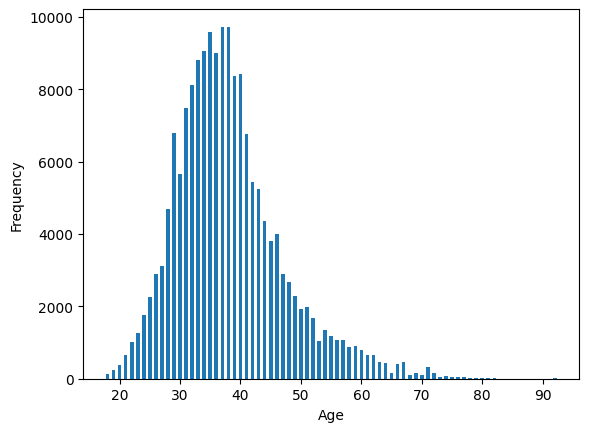

In [14]:
values , freq = X['Age'].value_counts().reset_index().values.T
plt.bar(values , freq , width=0.6)
plt.xlabel('Age')
plt.ylabel("Frequency")

In [15]:
to_plot = list(cat_features) + ['Tenure','NumOfProducts', 'HasCrCard', 'IsActiveMember']

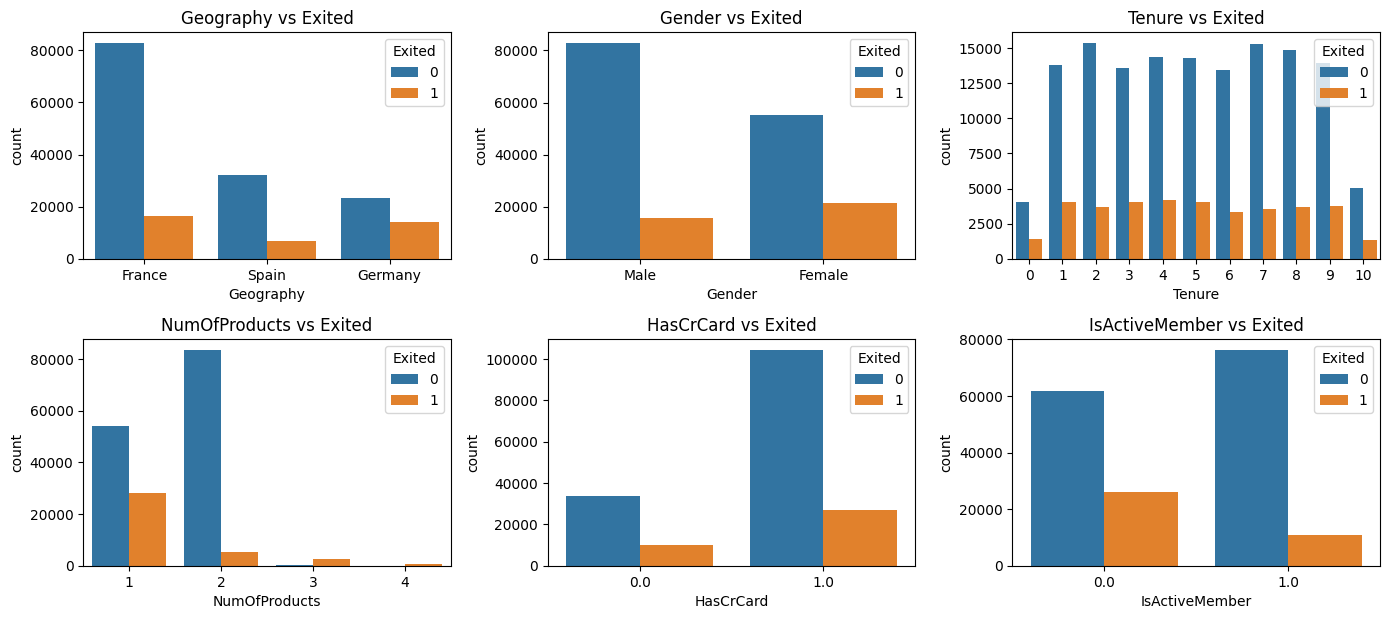

In [16]:
plt.figure(figsize=(14, len(to_plot) * 2))
for i, col in enumerate(to_plot):
    plt.subplot(len(to_plot) // 2 + 1, 3, i + 1)
    sns.countplot(x=col, hue=target, data=train)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()

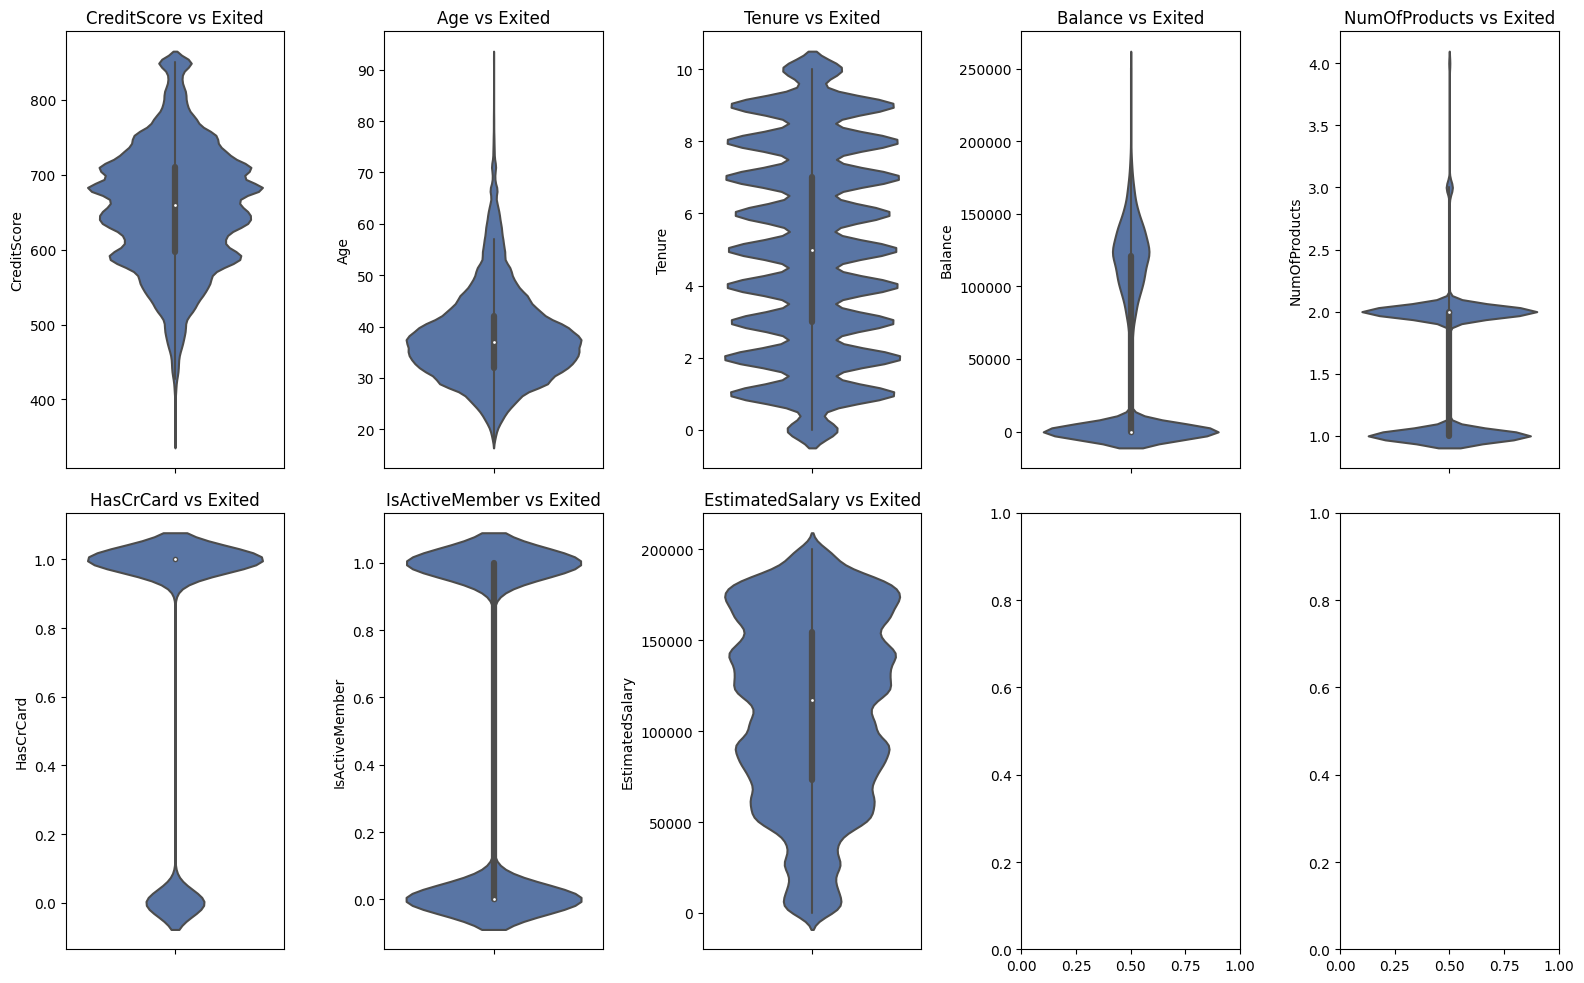

In [17]:
fig , axes = plt.subplots(2,5,figsize=(16,10))
sns.set(style='white')
for i,ax in enumerate(axes.flatten()):
    if i<len(con_features):
        sns.violinplot(data=train , ax=ax , hue=target , y=con_features[i])
        ax.set_title(f'{con_features[i]} vs {target}')
plt.tight_layout()
plt.show()

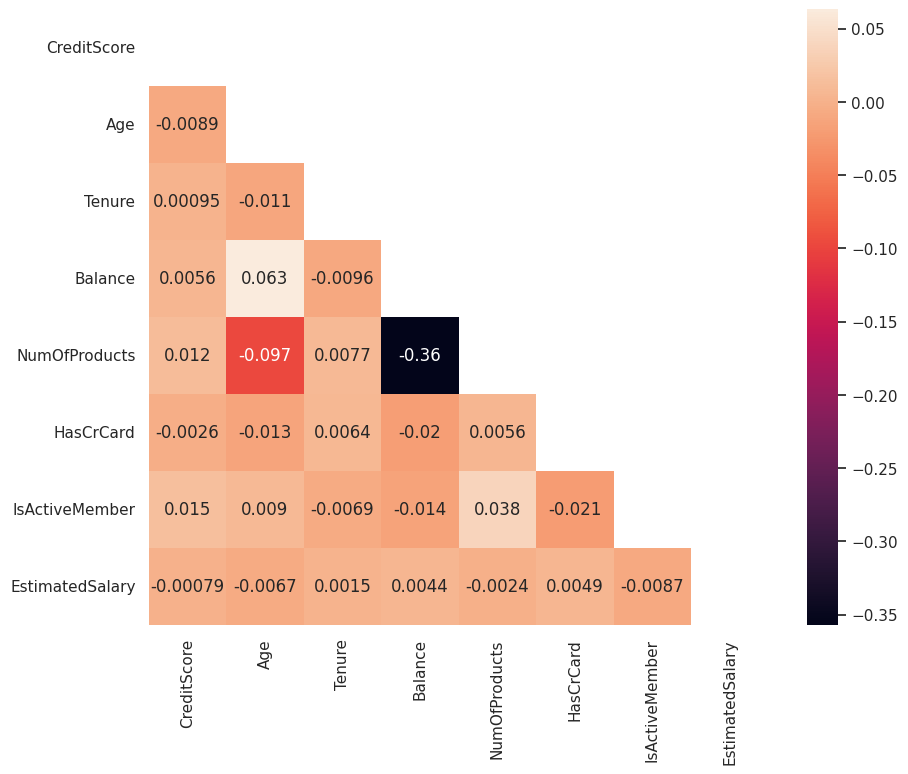

In [18]:
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(X[con_features].corr(), dtype=bool))
sns.heatmap(X[con_features].corr(), annot=True, mask=mask)
plt.show()

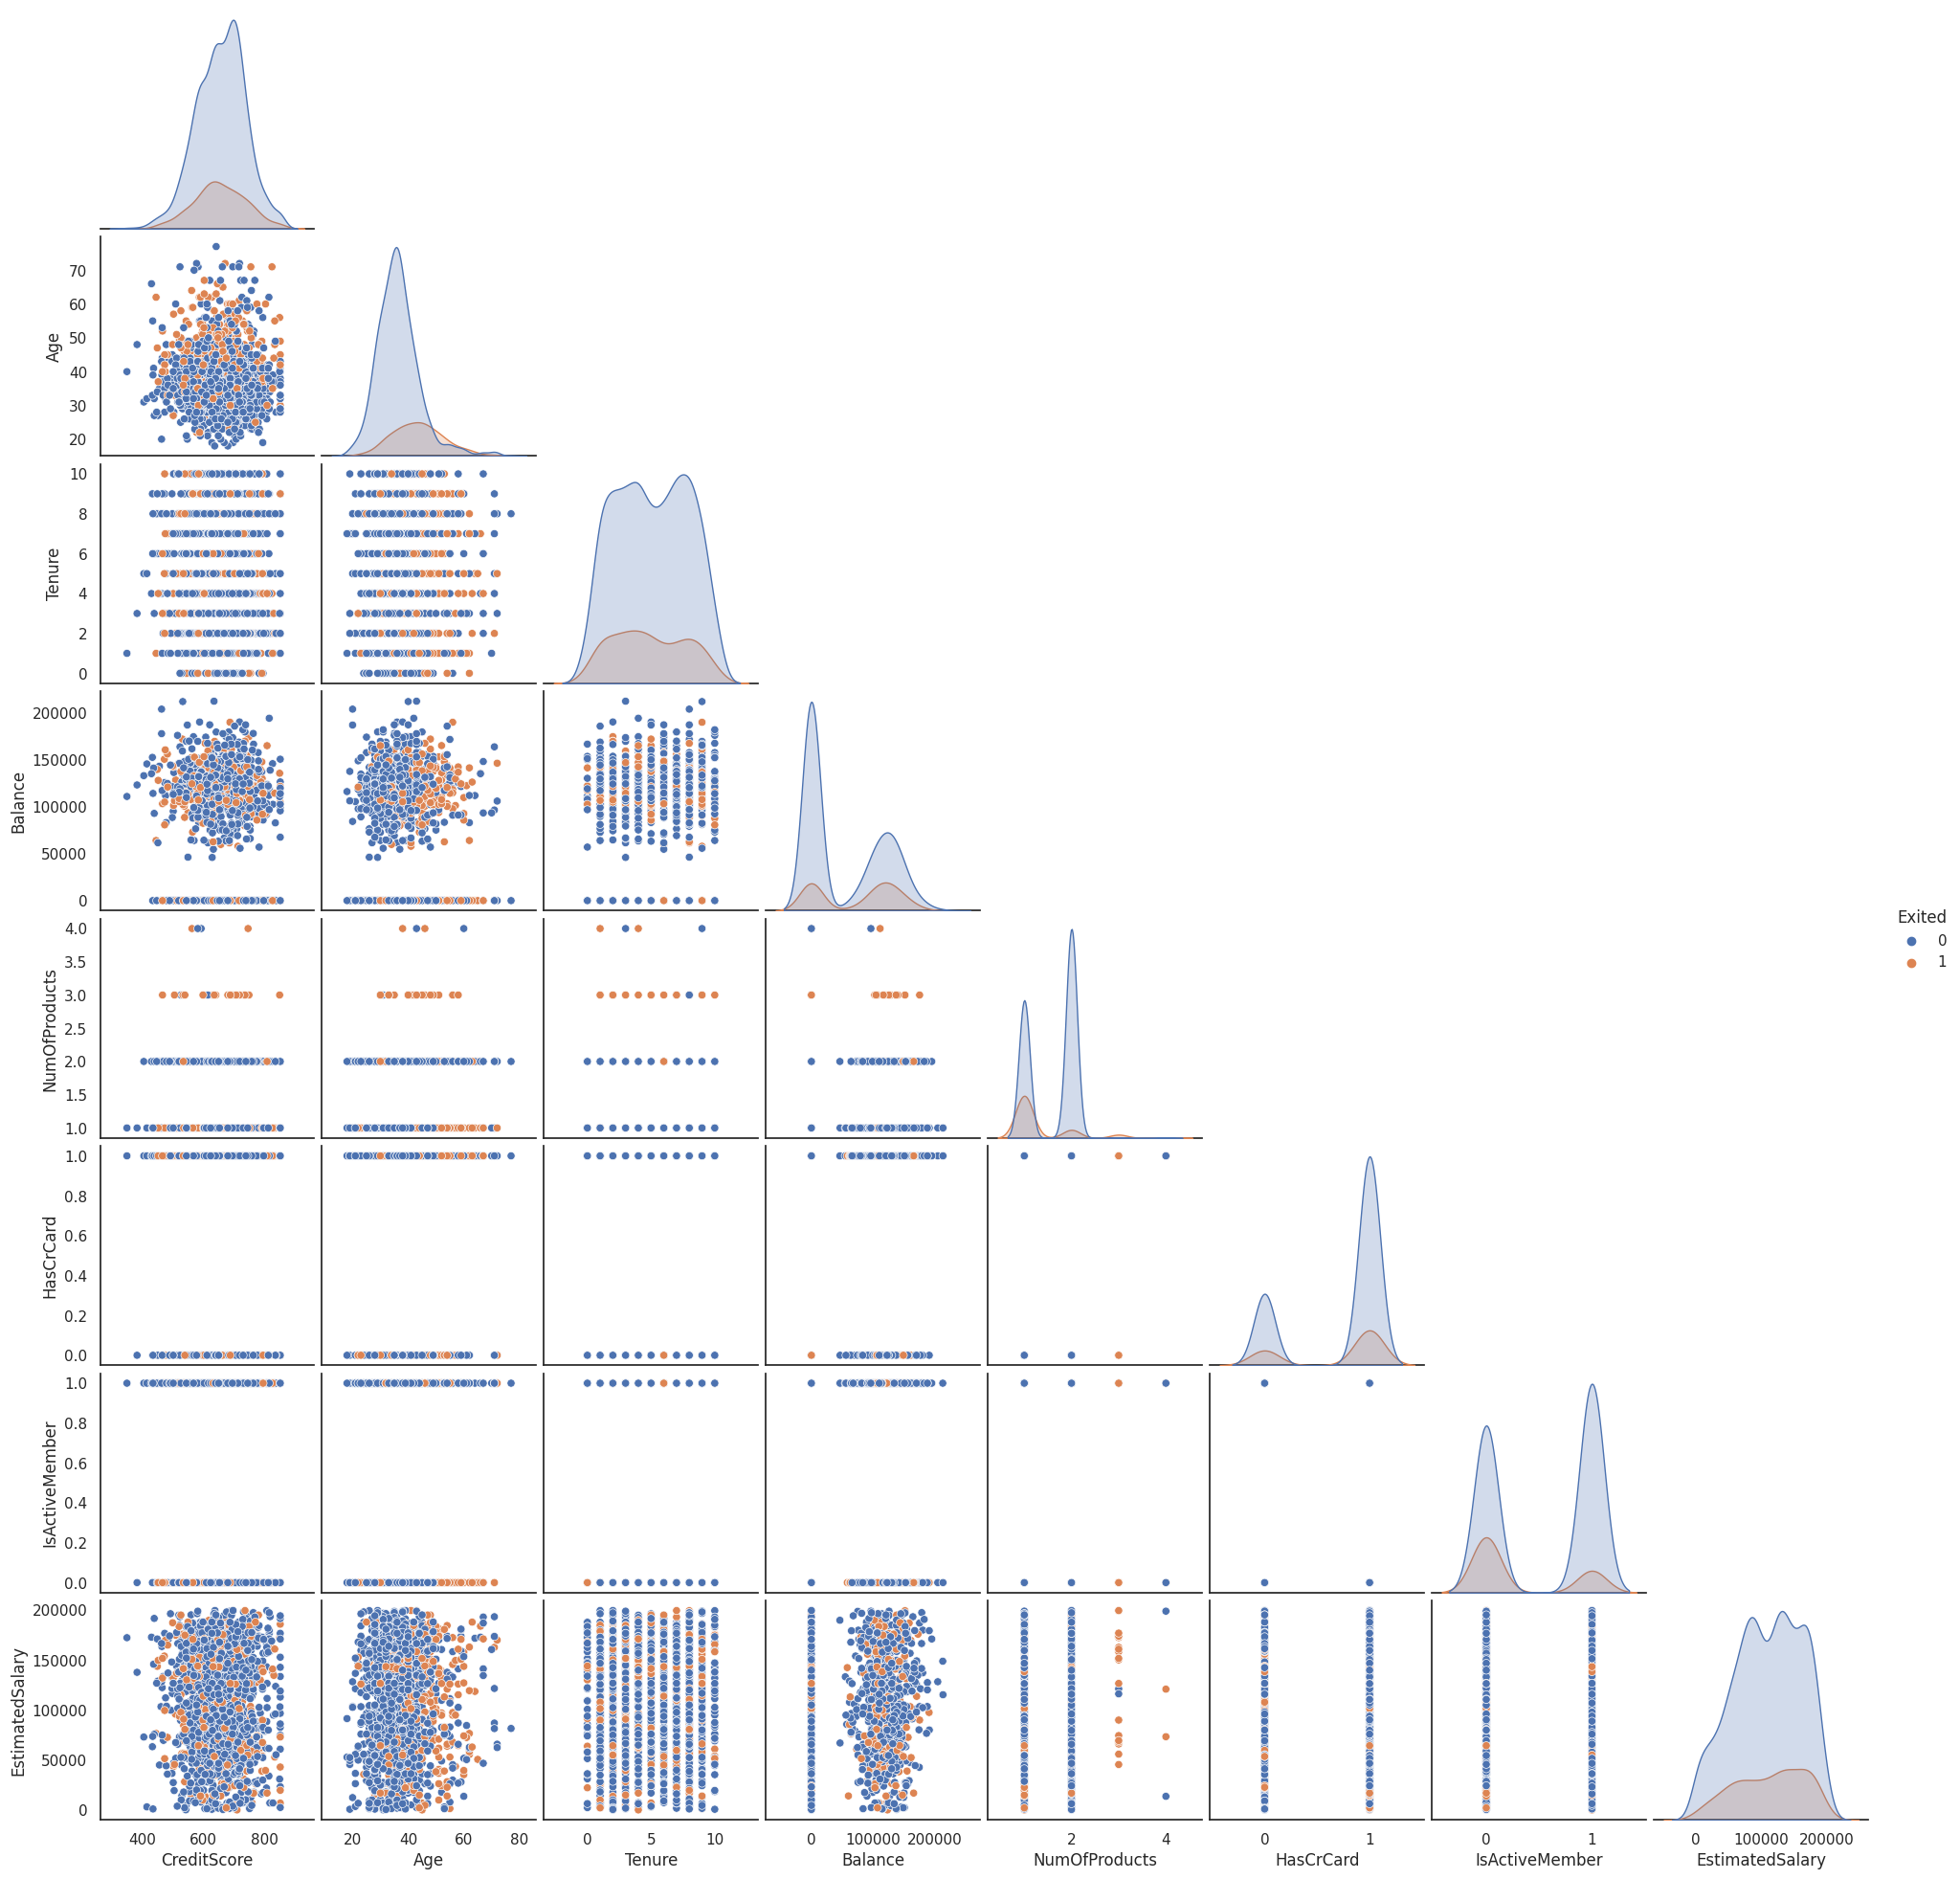

In [19]:
pairplot = sns.pairplot(train[list(con_features) + [target]].sample(frac=.01) ,
                        hue= target,
                        corner=True)

In [20]:
print(len(con_features))

8


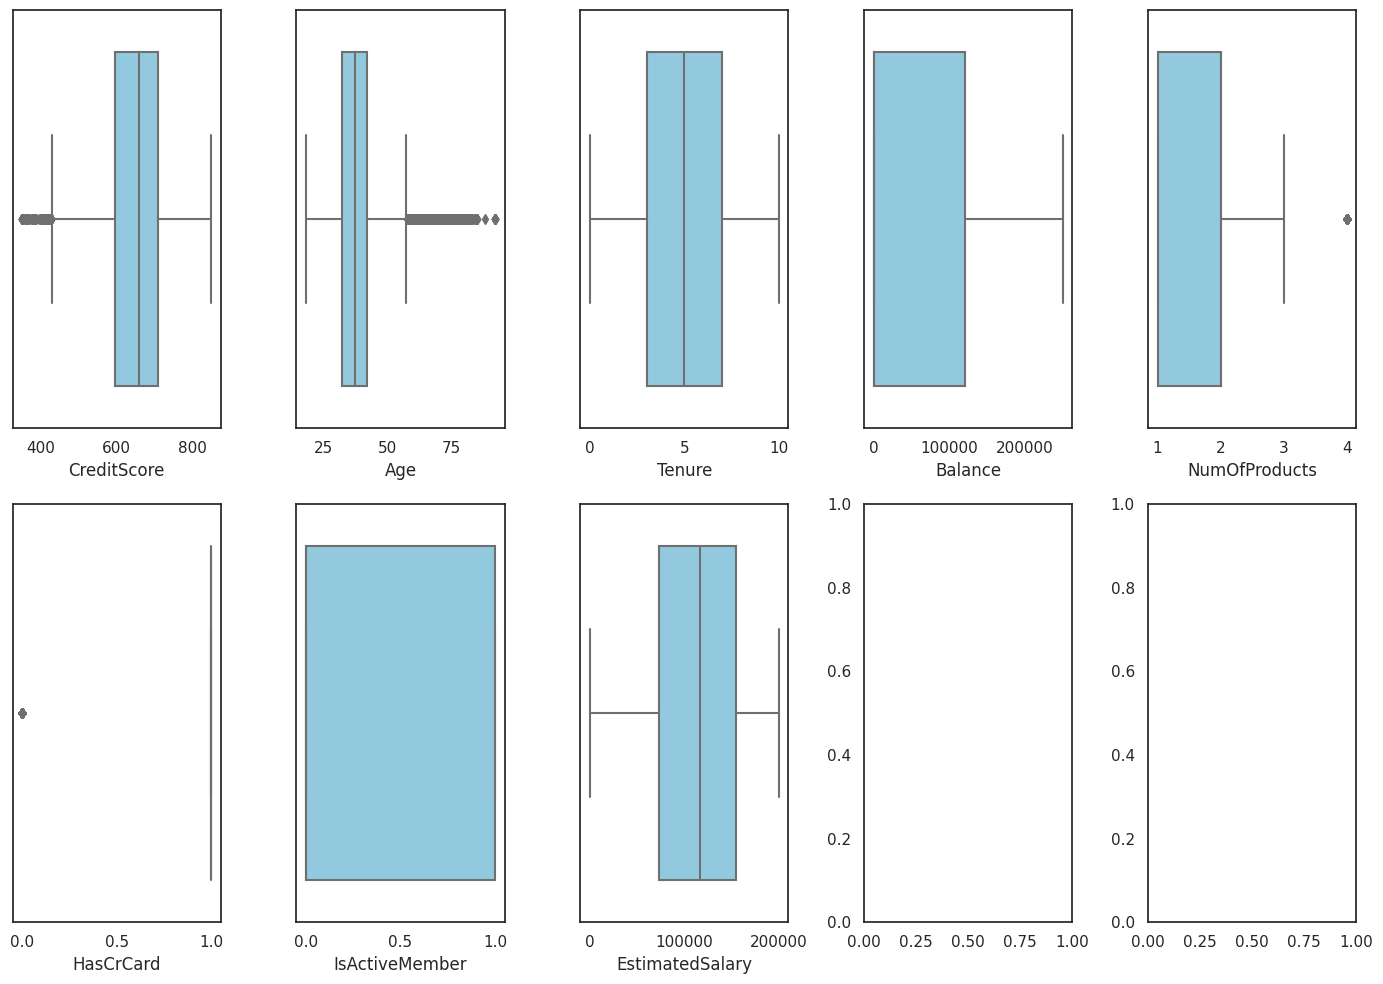

In [21]:
fig, axes = plt.subplots(2,5,figsize=(14,10))
for i , (col ,ax) in enumerate(zip(con_features , axes.flatten())):
    if i<len(con_features):
        sns.boxplot(x=X[col] , ax=ax ,  color='skyblue')
plt.tight_layout()
plt.show()

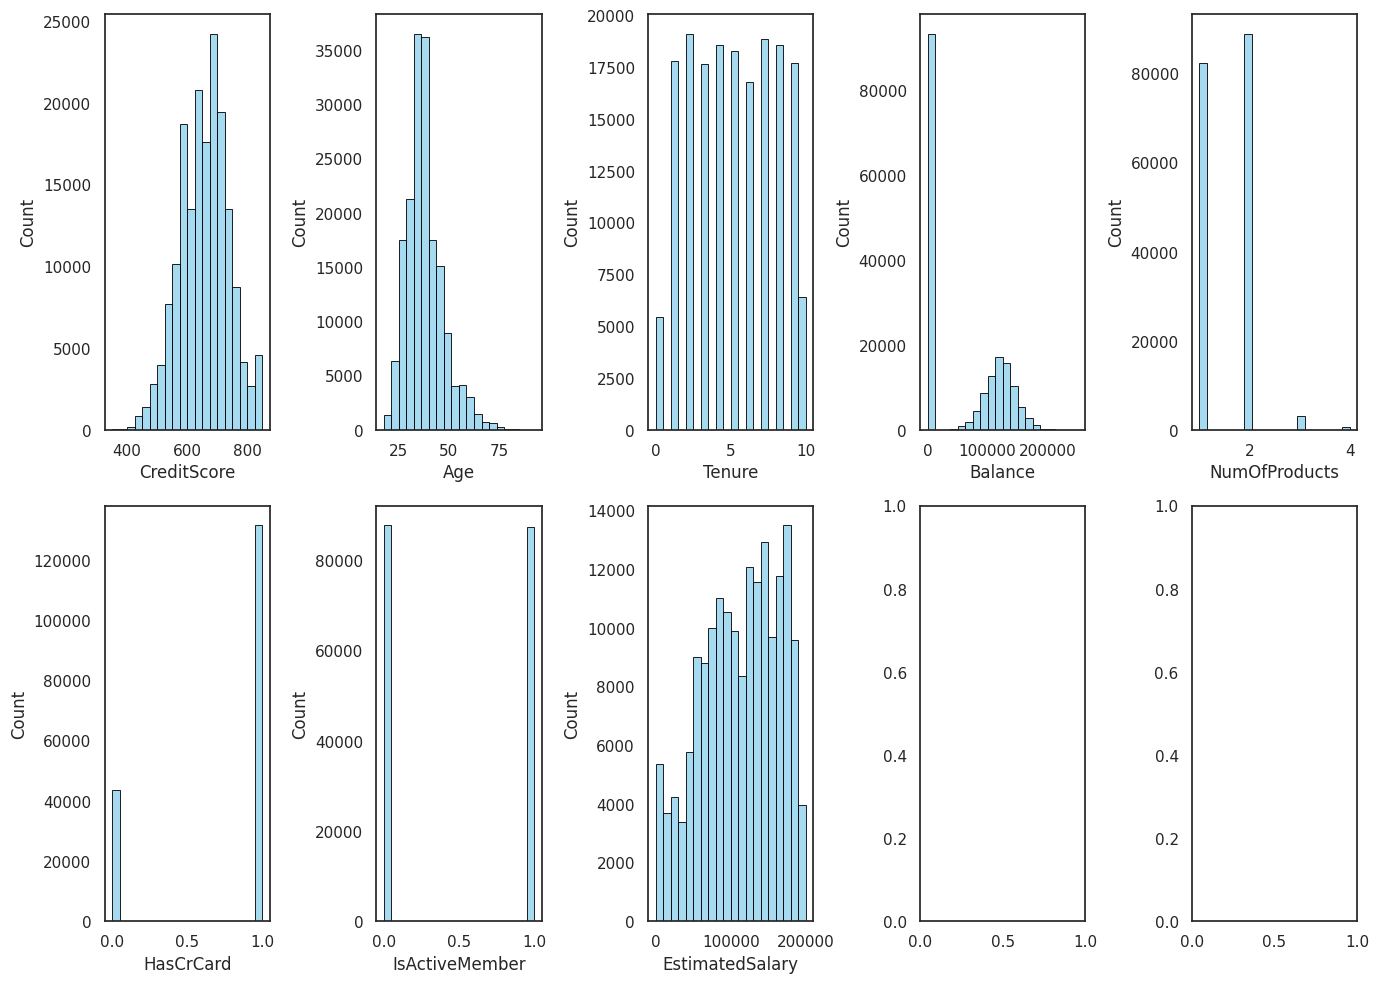

In [22]:
fig, axes = plt.subplots(2,5,figsize=(14,10))
for i , (col ,ax) in enumerate(zip(con_features , axes.flatten())):
    if i<len(con_features):
        sns.histplot(x=X[col] , bins=20, ax=ax, edgecolor='black' , color='skyblue')
plt.tight_layout()
plt.show()

# Data Pre_processing

### Outlier detection and removal

In [23]:
num_features = ["CreditScore", "Balance", "EstimatedSalary"]

##### Method 1 (Z_score)

In [24]:
z_score = np.abs(stats.zscore(X[num_features]))
threshold = 3

outlier_ind = np.where(z_score>threshold)
print(len(outlier_ind[0]))

153


In [25]:
# Removing the outlier
X = X[(z_score<threshold).all(axis=1)].reset_index(drop=True)
y = y[(z_score<threshold).all(axis=1)].reset_index(drop=True)


In [26]:
print(X.shape)
print(X_test.shape)
print(y.shape)

(174877, 10)
(110023, 10)
(174877,)


##### Method 2 (Mean and std)

In [27]:
mean = X["Age"].mean()
std = X["Age"].std()

# Setting threshold to be considered as outlier  , typically 3+
n_std =4
threshold = n_std*std

outlier = (np.abs(X["Age"]- mean) > threshold)
print(outlier)
print(f"Detected {sum(outlier)} more than {n_std} stds away from  mean")


0         False
1         False
2         False
3         False
4         False
          ...  
174872    False
174873    False
174874    False
174875    False
174876    False
Name: Age, Length: 174877, dtype: bool
Detected 254 more than 4 stds away from  mean


In [28]:
# Overwrite the train data
X = X[~outlier].reset_index(drop=True)
y = y[~outlier].reset_index(drop=True)
print(f"X_Train data shape after outlier removal: {X.shape}")
print(f"y_train data shape after outlier removal: {y.shape}")

X_Train data shape after outlier removal: (174623, 10)
y_train data shape after outlier removal: (174623,)


## Feature engineering 

### Creating new features

1. age_tr -- we will convert age to bins (i.e. categorize them in intervals ) : this allows to group the ages and potentially increases the models performance

2. Geo_gen -- this features will contain the distribution of gender with respect to locations (eg. spain_male ,spain_female, etc)

3. cbs -- this take some of the important feature and make feature dependent of these three (it has high feature importance too )

4. bal_est -- similar to cbs this combines the important information from balance and estimated salary details.

5. tenure_age : on of the important feature which tell how the tenure pre unit age is useful for determining the state of customer.

6. age_ten_prod : product of  age and tenure , similar to tenure_age feature.

In [29]:
## Categorical

def age_tr(df) : 
    df['Age_Category'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])
    return df

def geo_gen(df):
    df["Geo_Gender"] = df["Geography"]+ "_"+ df["Gender"]
    return df

## Continous feature

def cbs(df):
    df["Cred_Bal_Sal"] = (df["CreditScore"] * df["Balance"] ) / df["EstimatedSalary"]
    return df

def bal_est(df):
    df["Bal_sal"] = df["Balance"] / df["EstimatedSalary"]
    return df

def tenure_age(df):
    df["Tenure_Age"] = df["Tenure"] / df["Age"]
    return df

def age_ten_prod(df):
    df["Age_Tenure_product"] = df["Age"] * df["Tenure"]
    return df

# X = age_tr(X)
# X_test = age_tr(X_test)

In [30]:
dfs =[X ,X_test]

for i in dfs:
    i=age_tr(i)
#     i=geo_gen(i)
    i=cbs(i)
    i=bal_est(i)
    i=tenure_age(i)
    i=age_ten_prod(i)

In [31]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_Category,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,30-40,0.000000,0.000000,0.090909,99.0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,30-40,0.000000,0.000000,0.030303,33.0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,30-40,0.000000,0.000000,0.250000,400.0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,30-40,1022.940581,1.760655,0.058824,68.0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,30-40,0.000000,0.000000,0.151515,165.0


In [32]:
X_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_Category,Cred_Bal_Sal,Bal_sal,Tenure_Age,Age_Tenure_product
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,18-30,0.000000,0.000000,0.086957,46.0
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,40-50,0.000000,0.000000,0.043478,92.0
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,30-40,0.000000,0.000000,0.205882,238.0
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,30-40,0.000000,0.000000,0.222222,288.0
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,30-40,654.016985,0.869703,0.263158,380.0


## Encoding & Normalization

In [33]:
Categ_feat = list(X.select_dtypes(include=["object","category"]).columns)
Numer_feat = list(X.drop(columns=Categ_feat).columns)

In [34]:
print(Numer_feat)
print(Categ_feat)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Cred_Bal_Sal', 'Bal_sal', 'Tenure_Age', 'Age_Tenure_product']
['Geography', 'Gender', 'Age_Category']


In [35]:
to_remove = ["Tenure","NumOfProducts" , "HasCrCard" ,"IsActiveMember"]
to_scale = [k for k in Numer_feat if k not in to_remove]
print(to_scale)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Cred_Bal_Sal', 'Bal_sal', 'Tenure_Age', 'Age_Tenure_product']


In [36]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse_output=False)
scaler_min = MinMaxScaler()
scaler_std = StandardScaler()

def OHE(x_train , x_test , feature):
    new_col = one_hot_encoder.fit_transform(x_train[[feature]] )
    cols = one_hot_encoder.get_feature_names_out([feature])
    x_train[cols] = new_col
    x_train.drop([feature] ,axis=1 , inplace=True)

    new_col_test = one_hot_encoder.transform(x_test[[feature]])
    cols_test = one_hot_encoder.get_feature_names_out([feature])
    x_test[cols_test] = new_col_test
    x_test.drop([feature] ,axis=1 , inplace=True)

def Lab(x_train , x_test , feature):
    x_train[feature] = label_encoder.fit_transform(x_train[feature])
    x_test[feature] = label_encoder.transform(x_test[feature])

def scal(x_train ,x_test , features, scaler=scaler_min):
    x_train[features] = scaler.fit_transform(x_train[features])
    x_test[features] = scaler.transform(x_test[features])



In [37]:
# Using Lable encoder
Lab(X , X_test , 'Age_Category')

# Using One Hot Encoder
OHE(X , X_test , "Geography")
OHE(X , X_test , "Gender")
# OHE(X , X_test , "Geo_Gender")
OHE(X , X_test , "NumOfProducts")
# OHE(X , X_test , "HasCrCard")
# OHE(X , X_test , "IsActiveMember")

scal(X, X_test ,to_scale ,scaler=scaler_min)

# X[num_features] = scaler.fit_transform(X[num_features])
# X_test[num_features] = scaler.fit_transform(X_test[num_features])

X['Tenure'] = X['Tenure'] / 10.0
X_test['Tenure'] = X_test['Tenure'] / 10.0

# X['NumOfProducts'] = X['NumOfProducts'] / 4.0
# X_test['NumOfProducts'] = X_test['NumOfProducts'] / 4.0


In [38]:
X.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Age_Category,Cred_Bal_Sal,Bal_sal,...,Age_Tenure_product,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,0.583524,0.267857,0.3,0.00000,1.0,0.0,0.907279,1,0.000000,0.000000,...,0.133784,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.489703,0.267857,0.1,0.00000,1.0,1.0,0.247483,1,0.000000,0.000000,...,0.044595,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.606407,0.392857,1.0,0.00000,1.0,0.0,0.924364,1,0.000000,0.000000,...,0.540541,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.384439,0.285714,0.2,0.62454,1.0,1.0,0.422787,1,0.000118,0.000137,...,0.091892,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.693364,0.267857,0.5,0.00000,1.0,1.0,0.075293,1,0.000000,0.000000,...,0.222973,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [39]:
print(X.shape)
print(X_test.shape)
print(y.shape)

(174623, 21)
(110023, 21)
(174623,)


# Splitting data

In [40]:
X_train ,X_val , y_train , y_val = train_test_split(X ,y , test_size=0.2,random_state=2144)

# Model

In [41]:
def plot_learning_curve(estimator , X , y):

    train_sizes , train_scores , test_scores = learning_curve(
        estimator ,X ,y , n_jobs=1 , cv=5 , scoring='accuracy',
        train_sizes=np.linspace(0.1 ,1.0,10))

    train_mean = np.mean(train_scores , axis=1)
    train_std = np.std(train_scores , axis=1)
    test_mean = np.mean(test_scores , axis=1)
    test_std = np.std(test_scores , axis=1)

    plt.figure()
    plt.grid()
    plt.plot(train_sizes , train_mean , label='Training_score',color="blue",marker='o')
    plt.fill_between(train_sizes ,train_mean - train_std , train_mean+train_std , alpha=0.25,color="b")
    plt.plot(train_sizes, test_mean , label="Cross_validation_score" , color='red' , marker='o')
    plt.fill_between(train_sizes, test_mean-test_std , test_mean+test_std, alpha=0.25 , color='r' )
    plt.title("learning_curve")
    plt.xlabel("Training_size")
    plt.ylabel("accuracy_score")
    plt.legend()
    plt.show()

In [42]:
def plot_validation_curve(estimator , X ,y,param_name ,param_range):

    train_scores , test_scores = validation_curve(
        estimator ,X ,y , n_jobs=1 , cv=5 , scoring='accuracy',param_name=param_name , param_range=param_range)

    train_mean = np.mean(train_scores , axis=1)
    train_std = np.std(train_scores , axis=1)
    test_mean = np.mean(test_scores , axis=1)
    test_std = np.std(test_scores , axis=1)

    plt.figure()
    plt.grid()
    plt.plot(param_range , train_mean , label='Training_score',color="blue",marker='o')
    plt.fill_between(param_range ,train_mean - train_std , train_mean+train_std , alpha=0.25,color="b")
    plt.plot(param_range, test_mean , label="Cross_validation_score" , color='blue' , marker='o')
    plt.fill_between(param_range, test_mean-test_std , test_mean+test_std, alpha=0.25 , color='r' )
    plt.title("validation_curve")
    plt.xlabel("Training_size")
    plt.ylabel("accuracy_score")
    plt.legend()
    plt.show()

## Xgboost

In [43]:
# def objective_xgb(trial):
    
#     Xgb_params = {
#         'tree_method': 'hist',
#         # 'gpu_id':1,
#         # 'device': "cuda:0" ,
#         'booster': trial.suggest_categorical('booster', ['gbtree']),
#         'max_depth': trial.suggest_int('max_depth', 12, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.04, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 500, 930),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 1.2),
#         'subsample': trial.suggest_float('subsample', 0.3, 0.8),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
#         'colsample_bynode': trial.suggest_float('colsample_bynode', 0.3, 1),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.3, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.3,log=True),
# #         'gamma': trial.suggest_float('gamma', 1e-8, 1.0 ),
#         'eval_metric':trial.suggest_categorical('eval_metric', ['auc']),
#         'objective':trial.suggest_categorical('objective', ['binary:logistic']),
#     }
#     Xgb = xgb.XGBClassifier(**Xgb_params,random_state=2668)
#     Xgb.fit(X_train,y_train,eval_set=[(X_val , y_val)] ,verbose=False )
    
#     y_pred = Xgb.predict_proba(X_val)
#     # Show the log loss score directly
#     score = roc_auc_score(y_val, y_pred[:,1])
#     return score

# study_xgb = optuna.create_study(direction='maximize')

# study_xgb.optimize(objective_xgb, n_trials=10, show_progress_bar=False)


In [44]:
# best_params_xgb = study_xgb.best_params
# print('Best XGBoost Hyperparameters:', best_params_xgb)

In [45]:
# xgb_params={'tree_method': 'hist', 'booster': 'gbtree', 'max_depth': 12, 'learning_rate': 0.028029897743658588, 'n_estimators': 612, 'min_child_weight': 0.09526612990793319, 'subsample': 0.7991559404011698, 'colsample_bylevel': 0.49165813159506155, 'colsample_bytree': 0.29075580997345946, 'colsample_bynode': 0.8734171806923849, 'reg_alpha': 1.2211801863426914, 'reg_lambda': 0.1583734014365548, 'eval_metric': 'auc', 'objective': 'binary:logistic'}
xgb_params = {'tree_method':'hist','booster': 'gbtree', 'max_depth': 18, 'learning_rate': 0.018065065118176248, 'n_estimators': 882, 'min_child_weight': 0.5365530787350117, 'subsample': 0.6543908827142921, 'colsample_bylevel': 0.3809585293303984, 'colsample_bytree': 0.444503075408884, 'colsample_bynode': 0.44788723252995644, 'reg_alpha': 0.1575812696380722, 'reg_lambda': 0.2272884878052778, 'eval_metric': 'auc', 'objective': 'binary:logistic'}

Xgb = xgb.XGBClassifier( **xgb_params)

In [46]:
plot_learning_curve(Xgb ,X_train,y_train)

KeyboardInterrupt: 

In [ ]:
# param_range=[0.01 , 0.2 ,0.4 ,0.8,2,3]
# plot_validation_curve(Xgb , X_train,y_train,"reg_alpha",param_range)

In [47]:
hist_xgb = Xgb.fit(X_train , y_train , eval_set=[(X_val , y_val)] ,early_stopping_rounds=30 ,verbose=True)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.70272
[1]	validation_0-auc:0.79164
[2]	validation_0-auc:0.81262
[3]	validation_0-auc:0.84332
[4]	validation_0-auc:0.85202
[5]	validation_0-auc:0.86332
[6]	validation_0-auc:0.86259
[7]	validation_0-auc:0.86669
[8]	validation_0-auc:0.86916
[9]	validation_0-auc:0.86985
[10]	validation_0-auc:0.87457
[11]	validation_0-auc:0.87360
[12]	validation_0-auc:0.87378
[13]	validation_0-auc:0.87226
[14]	validation_0-auc:0.87354
[15]	validation_0-auc:0.87238
[16]	validation_0-auc:0.87215
[17]	validation_0-auc:0.87082
[18]	validation_0-auc:0.86989
[19]	validation_0-auc:0.86887
[20]	validation_0-auc:0.86902
[21]	validation_0-auc:0.86848
[22]	validation_0-auc:0.86780
[23]	validation_0-auc:0.86981
[24]	validation_0-auc:0.87130
[25]	validation_0-auc:0.87148
[26]	validation_0-auc:0.87199
[27]	validation_0-auc:0.87173
[28]	validation_0-auc:0.87390
[29]	validation_0-auc:0.87398
[30]	validation_0-auc:0.87435
[31]	validation_0-auc:0.87381
[32]	validation_0-auc:0.87513
[33]	validation_0-au

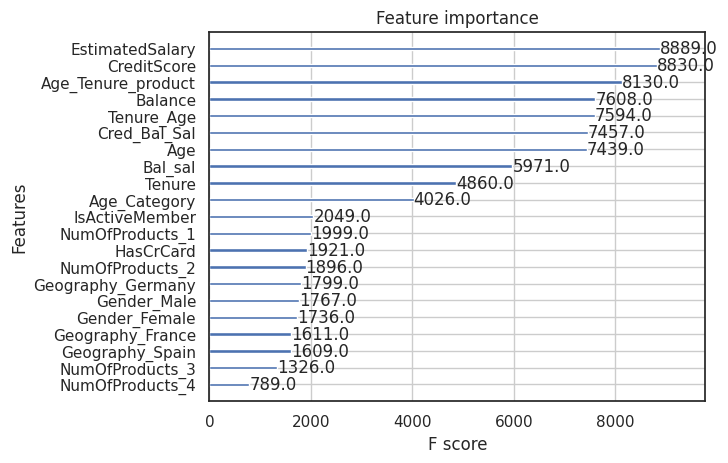

In [48]:
plot_importance(Xgb)
plt.show()

In [49]:
eval_prob_xgb = Xgb.predict_proba(X_val)
y_pred_xgb = np.argmax(eval_prob_xgb,axis=1)
accuracy = accuracy_score(y_val , y_pred_xgb)
print(accuracy)


0.8668002863278453


In [50]:
roc_score_xgb = roc_auc_score(y_val , y_pred_xgb)
print(roc_score_xgb)
cv_result = cross_val_score(Xgb, X_train , y_train, cv=5,scoring='accuracy')
print(cv_result)

0.7467045903919154
[0.86714388 0.86209735 0.86403006 0.86391782 0.8644547 ]


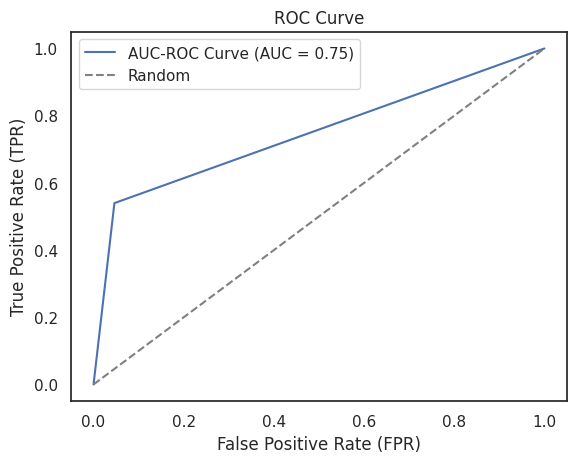

In [51]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb)

plt.plot(fpr, tpr, label=f'AUC-ROC Curve (AUC = {roc_score_xgb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


## Thank you guys for checking the notebook. 
## If you found this helpfull please Upvote 